# Binned fits solutions: exercise 12.3

Insert the source code of the previous exercise into a loop
that performs the comparison as the number of events considered for the fit varies,
from ```20``` to ```10000```, with a regular log-scale increment.
  * Use different plots
    to show the behavior of the parameters and their uncertainties
    as the number of events changes, for both types of estimators.
  * Add to the comparison the fit performed with the least squares method.
  * Which estimator is less biased at low statistics?


### binned likelihood
To determine the bias, the estimator expectation value is needed, hence for each sample size to be fitted several toy experiments need to be performed, and their average to be calculated

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from myrand import generate_TCL_ms
from iminuit import Minuit
from scipy.stats import norm
from iminuit.cost import ExtendedBinnedNLL
from math import floor, ceil, sqrt

# for the binning choice
def sturge (N) :
    return floor (1 + 3.322 * np.log (N))

sample_size = 20
N_toys = 50
N_evt = 10000
means_bin = []
sigmas_bin = []
events = []
while sample_size < N_evt :
    means_size = []
    sigmas_size = []
    for iToy in range (N_toys) :
        subsample = generate_TCL_ms (1., 0.7, sample_size)
        bin_content, bin_edges = np.histogram (subsample, bins = sturge (sample_size), 
                                               range = (floor (min (subsample)), ceil (max (subsample))))

        def mod_signal_bin (bin_edges, N_signal, mu, sigma):
            return N_signal * norm.cdf (bin_edges, mu, sigma)
        
        my_cost_func_bin = ExtendedBinnedNLL (bin_content, bin_edges, mod_signal_bin)
        my_minuit_bin = Minuit (
                                my_cost_func_bin, 
                                N_signal = sum (bin_content), 
                                mu = np.mean (subsample), 
                                sigma = np.std (subsample),
                               )
        my_minuit_bin.limits['N_signal', 'sigma'] = (0, None)
        my_minuit_bin.migrad ()
        if not my_minuit_bin.valid : continue
        means_size.append (my_minuit_bin.values[1])
        sigmas_size.append (my_minuit_bin.values[2])
    events.append (sample_size)
    means_bin.append ([np.mean (means_size), np.std (means_size)])
    sigmas_bin.append ([np.mean (sigmas_size), np.std (sigmas_size)])
    sample_size = sample_size * 2    

### unbinned likelihood

In [2]:
from iminuit.cost import UnbinnedNLL

def mod_signal_unb (x, mu, sigma) :
    return norm.pdf(x, mu, sigma)

sample_size = 20
means_unb = []
sigmas_unb = []
while sample_size < N_evt :
    means_size = []
    sigmas_size = []
    for iToy in range (N_toys) :
        subsample = generate_TCL_ms (1., 0.7, sample_size)
        my_cost_func_unb = UnbinnedNLL (subsample, mod_signal_unb)
        my_minuit_unb = Minuit (
                                my_cost_func_unb, 
                                mu = np.mean (subsample), 
                                sigma = np.std (subsample),
                               )
        my_minuit_unb.limits["sigma"] = (0, None)
        my_minuit_unb.migrad ()
        if not my_minuit_unb.valid : continue
        means_size.append (my_minuit_unb.values[0])
        sigmas_size.append (my_minuit_unb.values[1])
    
    means_unb.append ([np.mean (means_size), np.std (means_size)])
    sigmas_unb.append ([np.mean (sigmas_size), np.std (sigmas_size)])
    sample_size = sample_size * 2    

### least squares

In [9]:
from iminuit.cost import LeastSquares

def sturges (N_events) :
    return ceil (1 + 3.322 * np.log (N_events))

def func_approx (x, N_events, mean, sigma, bin_width) :
    return N_events * norm.pdf (x, mean, sigma) * bin_width

sample_size = 20
means_ls = []
sigmas_ls = []
while sample_size < N_evt :
    means_size = []
    sigmas_size = []
    for iToy in range (N_toys) :
        subsample = generate_TCL_ms (1., 0.7, sample_size)
        bin_content, bin_edges = np.histogram (subsample, bins = sturges (sample_size), 
                                               range = (floor (min (subsample)), ceil (max (subsample))))
        bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        sigma_y = [max (sqrt (num), 1.) for num in bin_content]

        least_squares = LeastSquares (bin_centres, bin_content, sigma_y, func_approx)
        my_minuit_ls = Minuit (least_squares,
                               N_events = sample_size,
                               mean = np.mean (subsample), 
                               sigma = np.std (subsample),
                               bin_width = bin_centres[1] - bin_centres[0]
                              )
        my_minuit_ls.fixed["bin_width", "N_events"] = True
        my_minuit_ls.migrad ()
        my_minuit_ls.hesse ()
        if not my_minuit_ls.valid : continue
        means_size.append (my_minuit_ls.values[1])
        sigmas_size.append (my_minuit_ls.values[2])

    means_ls.append ([np.mean (means_size), np.std (means_size)])
    sigmas_ls.append ([np.mean (sigmas_size), np.std (sigmas_size)])
    sample_size = sample_size * 2            

### compare the three estimates

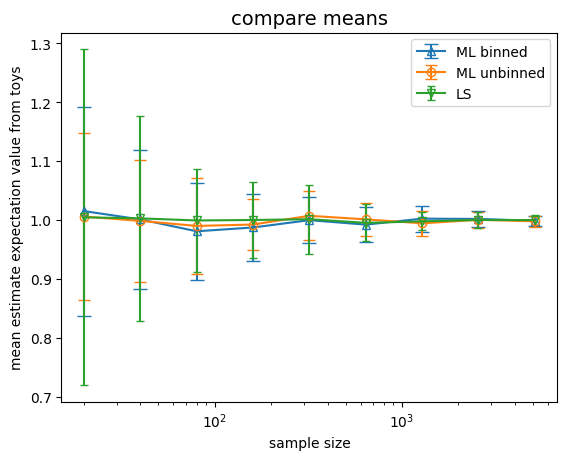

In [16]:
fig, ax = plt.subplots (1, 1)
ax.set_title ('compare means', size=14)
ax.set_xlabel ('sample size')
ax.set_ylabel ('mean estimate expectation value from toys')

means_bin_val, means_bin_err = map (list, zip (*means_bin))
ax.errorbar (events, means_bin_val, yerr = means_bin_err, marker = '^', markerfacecolor = 'none', label = 'ML binned', capsize = 5)

means_unb_val, means_unb_err = map (list, zip (*means_unb))
ax.errorbar (events, means_unb_val, yerr = means_unb_err, marker = 'o', markerfacecolor = 'none', label = 'ML unbinned', capsize = 4)

means_ls_val, means_ls_err = map (list, zip (*means_ls))
ax.errorbar (events, means_ls_val, yerr = means_ls_err, marker = 'v', markerfacecolor = 'none', label = 'LS', capsize = 3)

plt.xscale ("log")

ax.legend ()
plt.show ()

